# RHEED Simulation: MgO (001) Surface

This tutorial demonstrates kinematic RHEED simulation for MgO following the approach in arXiv:2207.06642.

## Experimental Setup
- **Crystal**: MgO (magnesium oxide, rock salt structure)
- **Surface**: (001) orientation
- **Electron energy**: 30 keV
- **Grazing angle**: 2°

## Expected Pattern
For MgO (001), we expect:
- Vertical streaks (crystal truncation rods)
- Mirror symmetry about the vertical axis
- FCC extinction rules (h,k,l all even or all odd)

In [1]:
import jax.numpy as jnp
import rheedium as rh
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

## Load Crystal Structure

In [3]:
crystal = rh.inout.parse_cif("../tests/test_data/MgO.cif")
print(f"Cell parameters: a={crystal.cell_lengths[0]:.3f} Å")
print(f"Number of atoms: {crystal.cart_positions.shape[0]}")

Cell parameters: a=4.256 Å
Number of atoms: 8


## Simulation Parameters

In [4]:
# RHEED simulation parameters
voltage_kV = 30.0        # Electron beam voltage
theta_deg = 2.0          # Grazing angle
hmax, kmax = 2, 2        # In-plane reciprocal lattice bounds
detector_distance = 80.0 # Sample-to-detector distance (mm)

# Calculate electron wavelength
wavelength = rh.simul.wavelength_ang(voltage_kV)
print(f"Electron wavelength: {float(wavelength):.4f} Å")

Electron wavelength: 0.0698 Å


## Spot Pattern (Discrete 3D Reciprocal Lattice)

The `kinematic_spot_simulator` treats the reciprocal lattice as discrete 3D points.
This produces spots where integer (h,k,l) points intersect the Ewald sphere.

In [5]:
spot_pattern = rh.simul.kinematic_spot_simulator(
    crystal=crystal,
    voltage_kv=voltage_kV,
    theta_deg=theta_deg,
    hmax=hmax,
    kmax=kmax,
    lmax=20,
    detector_distance=detector_distance,
    tolerance=0.5,
)

print(f"Number of spots: {len(spot_pattern.intensities)}")

Number of spots: 1025


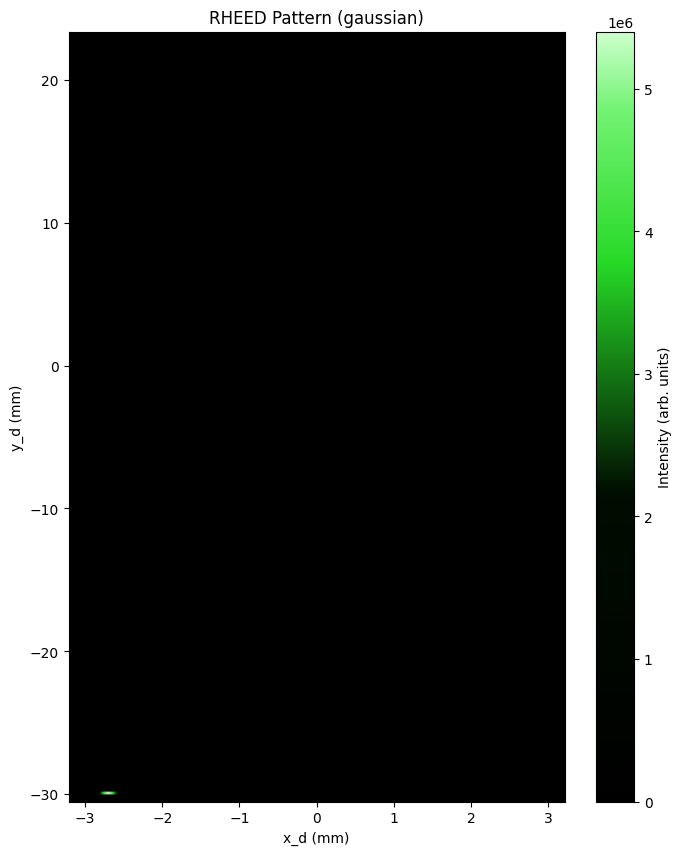

In [6]:
rh.plots.plot_rheed(spot_pattern, grid_size=300, interp_type="gaussian")

## Streak Pattern (Crystal Truncation Rods)

The `kinematic_ctr_simulator` models RHEED from surfaces where the reciprocal lattice
consists of continuous rods rather than discrete points. This produces the characteristic
vertical streaks seen in real RHEED patterns.

In [7]:
streak_pattern = rh.simul.kinematic_ctr_simulator(
    crystal=crystal,
    voltage_kv=voltage_kV,
    theta_deg=theta_deg,
    hmax=hmax,
    kmax=kmax,
    detector_distance=detector_distance,
    l_min=0.5,
    l_max=4.0,
    n_points_per_rod=200,
)

print(f"Number of streak points: {len(streak_pattern.intensities)}")
print(f"Number of unique rods: {len(jnp.unique(streak_pattern.G_indices))}")

Number of streak points: 5000
Number of unique rods: 13


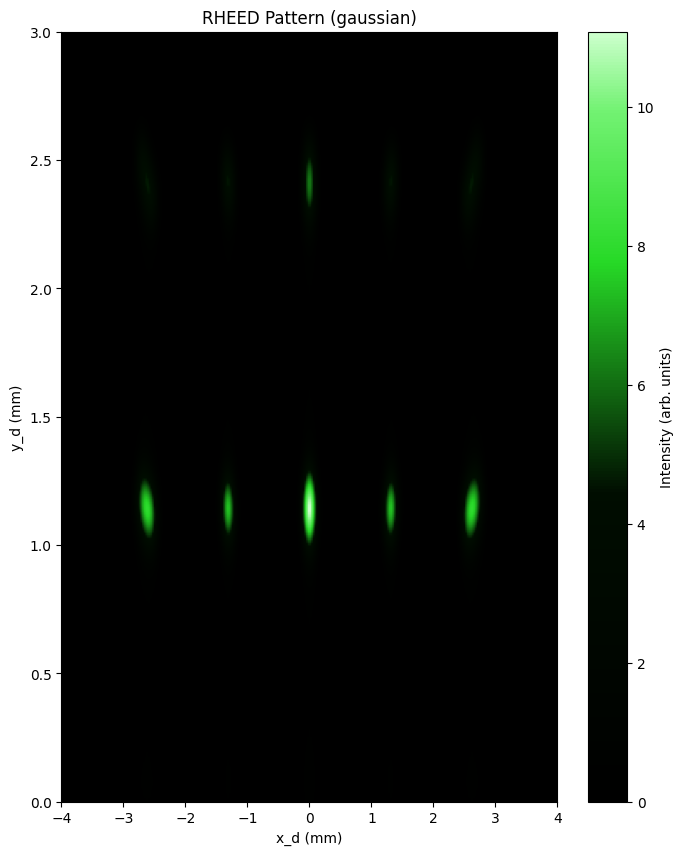

In [8]:
rh.plots.plot_rheed(
    streak_pattern,
    grid_size=300,
    interp_type="gaussian",
    x_extent=(-4.0, 4.0),
    y_extent=(0.0, 3.0),
)

## Alternative Visualization

Manual Gaussian broadening for finer control over spot width.

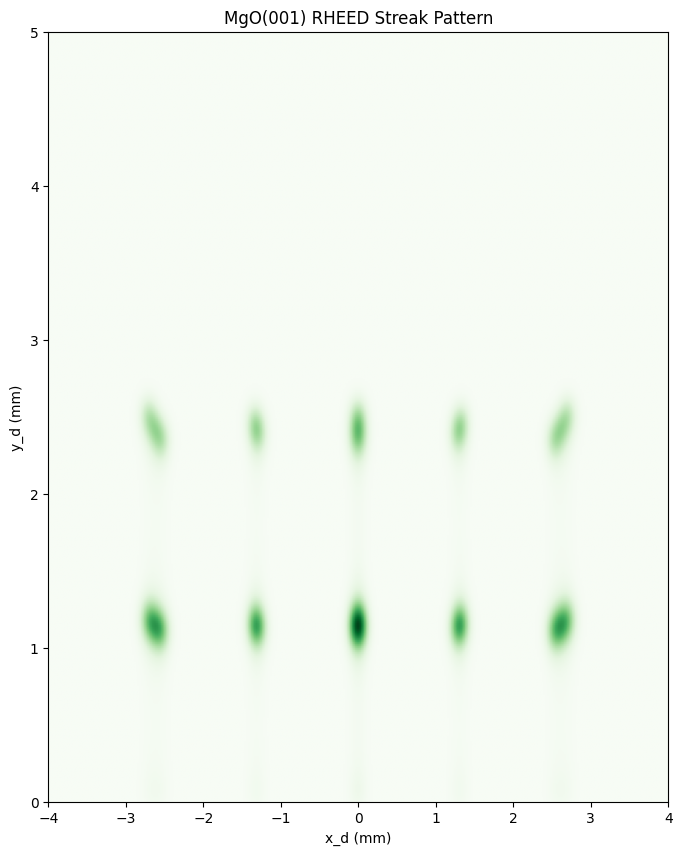

In [9]:
x_np = np.asarray(streak_pattern.detector_points[:, 0])
y_np = np.asarray(streak_pattern.detector_points[:, 1])
i_np = np.asarray(streak_pattern.intensities)

x_axis = np.linspace(-4, 4, 400)
y_axis = np.linspace(0, 5, 400)
xx, yy = np.meshgrid(x_axis, y_axis, indexing='xy')

image = np.zeros_like(xx)
spot_width = 0.08

for idx in range(len(i_np)):
    image += i_np[idx] * np.exp(-((xx - x_np[idx])**2 + (yy - y_np[idx])**2) / (2 * spot_width**2))

fig, ax = plt.subplots(figsize=(8, 10))
ax.imshow(image, extent=[-4, 4, 0, 5], origin='lower', cmap='Greens', aspect='auto')
ax.set_xlabel('x_d (mm)')
ax.set_ylabel('y_d (mm)')
ax.set_title('MgO(001) RHEED Streak Pattern')
plt.show()